## Analysing H1B Acceptance Trends 

H1B visa is a nonimmigrant visa issued to gradute level applicants allowing them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.\
**Motivation**: Our team consists of five international gradute students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa. 

### Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a>The Data provides insight into each petition with information such as the Job title, Wage, Employer, Worksite location etc. To get the dataset click on the above link-> click on Disclosure data -> scroll down to H1B data.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install autocorrect
import nltk,warnings
from textblob import TextBlob
from autocorrect import Speller 
nltk.download('wordnet')
import pandas as pd
import numpy as np

In [0]:
import clean_wage as cw

### Exploratory Data Analysis

Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc. 

In [0]:
file=pd.read_csv('/content/gdrive/My Drive/H-1B_Disclosure_Data_FY2019.csv')#Read the csv file and store it in file
file.shape

In [92]:
cleaned=file[['CASE_NUMBER','CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','FULL_TIME_POSITION','JOB_TITLE','SOC_CODE','SOC_TITLE',\
              'EMPLOYER_NAME','WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1','NAICS_CODE','WORKSITE_CITY_1','WORKSITE_STATE_1']]
cleaned.shape

(1048548, 15)

In [63]:
cleaned['VISA_CLASS'].value_counts() # similarly we can find the categories in CASE_STATUS and 'FULL_TIME_POSITION'

H-1B               649083
E-3 Australian      13087
H-1B1 Singapore      1291
H-1B1 Chile          1155
Name: VISA_CLASS, dtype: int64

In [0]:
# Visa class has many categories which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)
#In case status we can drop withdrawn records and we can change certified-withdrawn to certified
cleaned.replace({"CASE_STATUS":"CERTIFIED-WITHDRAWN"},"CERTIFIED",inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
cleaned.head(2)

In [65]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CASE_NUMBER              629855 non-null  object 
 1   CASE_STATUS              629856 non-null  object 
 2   CASE_SUBMITTED           629856 non-null  object 
 3   DECISION_DATE            629856 non-null  object 
 4   VISA_CLASS               629856 non-null  object 
 5   FULL_TIME_POSITION       629856 non-null  object 
 6   JOB_TITLE                629856 non-null  object 
 7   SOC_CODE                 629852 non-null  object 
 8   SOC_TITLE                629852 non-null  object 
 9   EMPLOYER_NAME            629848 non-null  object 
 10  WAGE_RATE_OF_PAY_FROM_1  629852 non-null  object 
 11  WAGE_UNIT_OF_PAY_1       629852 non-null  object 
 12  NAICS_CODE               629855 non-null  float64
 13  WORKSITE_CITY_1          629785 non-null  object 
 14  WOR

In [66]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(type).value_counts()

<class 'float'>    460442
<class 'str'>      169414
Name: WAGE_RATE_OF_PAY_FROM_1, dtype: int64

In [68]:
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(cw.clean_wages).astype('float')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
# the wage information that we have available has different unit of pay
cleaned['WAGE_UNIT_OF_PAY_1'].value_counts()

Year         587386
Hour          41927
Month           342
Bi-Weekly       105
Week             92
Name: WAGE_UNIT_OF_PAY_1, dtype: int64

In [0]:
# we convert the different units of pay to the type 'Year'
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Month',cleaned['WAGES'] * 12,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Hour',cleaned['WAGES'] * 2080,cleaned['WAGES']) # 2080=8 hours*5 days* 52 weeks
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Bi-Weekly',cleaned['WAGES'] *26,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Week',cleaned['WAGES'] * 52,cleaned['WAGES'])

In [0]:
#As we have got the information of Wages and made transformation we can drop the initial two records
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1'],axis=1,inplace=True)
cleaned.dropna(inplace=True)# We can check if we have null records using cleaned.info() and drop null records

In [0]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace(',', '')
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned['SOC_TITLE'].str.replace(',', '')

In [0]:
nltk.download('words')
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())
spell = Speller()
def lemmatize_text(text):
  return lemmatizer.lemmatize(text)
def spelling_checker(text):
  return spell(text)

In [0]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))

In [0]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))

In [0]:
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
cleaned = cleaned.groupby("SOC_TITLE").filter(lambda x: len(x) > 15)

In [0]:
cleaned = cleaned.groupby("SOC_CODE").filter(lambda x: len(x) > 15)
cleaned['EMPLOYER_NAME'].value_counts()
cleaned = cleaned.groupby("EMPLOYER_NAME").filter(lambda x: len(x) > 15)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
Top_Employer=cleaned['EMPLOYER_NAME'].value_counts()[:10]

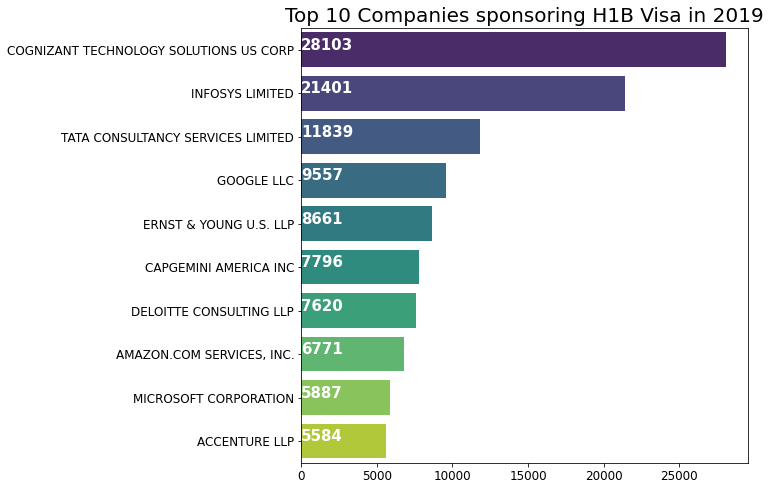

In [80]:
plt.figure(figsize=[8,8])
ax=sns.barplot(y=Top_Employer.index,x=Top_Employer.values,palette=sns.color_palette('viridis',10))
ax.tick_params(labelsize=12)
for i, v in enumerate(Top_Employer.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
plt.title('Top 10 Companies sponsoring H1B Visa in 2019', fontsize=20)
plt.show()

In [0]:
import remove

In [0]:
cleaned['WAGE_CATEGORY'] = cleaned['WAGES'].apply(remove.wage_feature_eng)

In [0]:
state={"AL":"ALABAMA","AK":"ALASKA","AZ":"ARIZONA","AR":"ARKANSAS","CA":"CALIFORNIA","CO":"COLORADO","DE":"DELAWARE",\
       "FL":"FLORIDA","GA":"GEORGIA","HI":"HAWAII","ID":"IDAHO","IL":"ILLINOIS","IN":"INDIANA","IA":"IOWA","KS":"KANSAS",\
       "KY":"KENTUCKY","LA":"LOUISIANA","ME":"MAINE","MD":"MARYLAND","MA":"MASSACHUSETTS","MI":"MICHIGAN","MN":"MINNESOTA",\
       "MS":"MISSISSIPPI","MO":"MISSOURI","MT":"MONTANA","NE":"NEBRASKA","NV":"NEVADA","NH":"NEW HAMPSHIRE","NJ":"NEW JERSEY",\
       "NM":"NEW MEXICO","NY":"NEW YORK","NC":"NORTH CAROLINA","ND":"NORTH DAKOTA","OH":"OHIO","OK":"OKLAHOMA","OR":"OREGON",\
       "PA":"PENNSYLVANIA","RI":"RHODE ISLAND","SC":"SOUTH CAROLINA","SD":"SOUTH DAKOTA","TN":"TENNESSEE","TX":"TEXAS",\
       "UT":"UTAH","VT":"VERMONT","VA":"VIRGINIA","WA":"WASHINGTON","WV":"WEST VIRGINIA","WI":"WISCONSIN","WY":"WYOMING",\
       "PR":"PUERTO RICO","VI":"U.S. VIRGIN ISLANDS","MP":"NORTHERN MARIANA ISLANDS","GU":"GUAM","MH":"MARSHALL ISLANDS",\
       "PW":"PALAU","DC":"DISTRICT OF COLUMBIA","CT":"CONNECTICUT"}
cleaned.replace({"WORKSITE_STATE_1": state})
cleaned = cleaned.groupby("WORKSITE_STATE_1").filter(lambda x: len(x) > 15) #removing less significant records

In [0]:
#CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS
cleaned.loc[(cleaned.CASE_STATUS == "CERTIFIED"),"CASE_STATUS"] = 1
cleaned.loc[(cleaned.CASE_STATUS == "DENIED"),"CASE_STATUS"] = 0

cleaned.loc[(cleaned.FULL_TIME_POSITION == "Y"),"FULL_TIME_POSITION"] = 1
cleaned.loc[(cleaned.FULL_TIME_POSITION == "N"),"FULL_TIME_POSITION"] = 0

### Baseline classifier

The baseline classifier is done with a basic model. In this case we are taking the mean of the labels ('certified' and 'denied' for H1B visa approvals). It will give us the base accuracy to which we will compare our classifier's accuracy. Our classifier should have a better accuracy than the baseline classifier accuracy.


In [0]:
# This step assigns a binary class label (0 or 1) to each label for H1B visa approval. 
#'CERTIFIED' is mapped to 1 and 'DENIED' to 0
def create_class_labels(processed_data):
    y = np.where((processed_data['CASE_STATUS']=='CERTIFIED'),1, 0)
    return y
X = cleaned['CASE_STATUS'].to_numpy()
# Groundtruth labels for the dataset
y = create_class_labels(cleaned)
counts = cleaned['CASE_STATUS'].value_counts()
print(counts)
print('proportion: ', counts[0]/counts[1], ': 1')

In [0]:
import sklearn
from statistics import mean
# Baseline classifier that predicts the class base on the mode of the labels.
class BaselineClasifier():
    def __init__(self):
        self.central_tendency = None
    def fit(self, data, y, central_t='mode'): 
        # Count labels and find the most frequent one
        label, counts = np.unique(y, return_counts=True) 
        if central_t == 'mode':
            self.central_tendency = counts.argmax()
        elif central_t == 'mean':
            self.central_tendency = round(np.sum(y)/len(y))
        
        return self
    # Return an array with size equal to the data size  and each element setted to the mode.
    def predict(self, data):
        result = np.full(data.shape[0], self.central_tendency)
        return result

In [0]:
def compute_accuracy(validation, predicted):
    comp = prediction == validation 
    match_counts = np.count_nonzero(comp == True) 
    clasifier_accuracy = match_counts/len(validation)
    return clasifier_accuracy  

In [0]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
def compute_AUC(y, prediction):
    auc = roc_auc_score(y, prediction)
    return auc

In [0]:
from sklearn import model_selection
# Testing with K-folds
accuracies = []
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True) 
for train_idx, test_idx in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx] 
    baseline_clasifier = BaselineClasifier()
    classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
    prediction = baseline_clasifier.predict(X_test)
    fold_accuracy = compute_accuracy(y_test, prediction)
    fold_AUC = compute_AUC(y_test, prediction)
    accuracies.append(fold_accuracy)
baseline_clasifier_accuracy = mean(accuracies)
print('Baseline accuracy: ', baseline_clasifier_accuracy) 

In [0]:
from sklearn.model_selection import train_test_split

# Testing with regular split

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
baseline_clasifier = BaselineClasifier()
classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
prediction = baseline_clasifier.predict(X_test)

split_accuracy = compute_accuracy(y_test, prediction)
split_AUC = compute_AUC(y_test, prediction)

print('Baseline accuracy: ', split_accuracy)  

The accuracy results of the baseline classifier is 0.99. This result is due to the highly imbalanced data, where there are 624682 CERTIFIED applications and 5158 DENIED applications. The proportion of it is 121.10934470725087 to 1. Therefore, a performance measure based on the accuracy is not a good one. A better performance measure in imbalanced data is the Area under the ROC Curve (AUC). It meassures the likelihood that given two random points (one from the positive and one from the negative class) the classifier will rank the point from the positive class higher than the one from the negative one.

In [0]:
print('K-fold: ', fold_AUC)
print('split (80-20): ', split_AUC)

In [0]:
Dataset = cleaned[["CASE_STATUS", "FULL_TIME_POSITION","JOB_TITLE", "SOC_CODE", "SOC_TITLE", "EMPLOYER_NAME", "WORKSITE_STATE_1", "WAGE_CATEGORY"]]

In [0]:
#Considered top positions in job roles
Top_Job_positions = Dataset["JOB_TITLE"].value_counts().head(72)
Top_Job_positions
Dataset.head(2)
def job_function(job):
    if job in Top_Job_positions:
        return job
    else:
        return "others"
Dataset["JOB_POSITION"] = Dataset["JOB_TITLE"].apply(job_function)
Dataset["JOB_POSITION"].value_counts()

In [0]:
#Considered top domains
Top_SOC_CODES = Dataset["SOC_CODE"].value_counts().head(70)
Top_SOC_CODES
Dataset.head(2)
def soc_function(soc):
    if soc in Top_SOC_CODES:
        return soc
    else:
        return "others"
Dataset["TOP_SOC_CODE"] = Dataset["SOC_CODE"].apply(soc_function)
Dataset["TOP_SOC_CODE"].value_counts()

In [0]:
#Considered names of top domains
Top_SOC_TITLE = Dataset["SOC_TITLE"].value_counts().head(70)
Top_SOC_TITLE
Dataset.head(2)
def soc_function(soc):
    if soc in Top_SOC_TITLE:
        return soc
    else:
        return "others"
Dataset["TOP_SOC_TITLE"] = Dataset["SOC_TITLE"].apply(soc_function)
Dataset["TOP_SOC_TITLE"].value_counts()

In [0]:
#Considered top employers
Top_EMPLOYER = Dataset["EMPLOYER_NAME"].value_counts().head(70)
Top_EMPLOYER
Dataset.head(2)
def emp_function(emp):
    if emp in Top_EMPLOYER:
        return emp
    else:
        return "others"
Dataset["TOP_EMPLOYER"] = Dataset["EMPLOYER_NAME"].apply(emp_function)
Dataset["TOP_EMPLOYER"].value_counts()

In [0]:
Dataset.drop(columns=['JOB_TITLE','SOC_CODE','SOC_TITLE','EMPLOYER_NAME',],axis=1,inplace=True)

In [0]:
#ONE HOT ENCODING
from sklearn.preprocessing import OneHotEncoder

In [0]:
Encoding = OneHotEncoder(handle_unknown='ignore',sparse = True)
Encoding_df = pd.DataFrame(SOC_Encoding.fit_transform(Dataset[["WORKSITE_STATE_1","JOB_POSITION","TOP_SOC_CODE","TOP_SOC_TITLE","TOP_EMPLOYER"]]).toarray())

In [0]:
Dataset = Dataset.join(Encoding_df)

In [0]:
Dataset.drop(columns=['WORKSITE_STATE_1','JOB_POSITION','TOP_SOC_CODE','TOP_SOC_TITLE','TOP_EMPLOYER','WAGE_CATEGORY'],axis=1,inplace=True)

In [0]:
#Split the date into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)

In [0]:
#Build model - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#model_clf = RandomForestClassifier(n_estimators=10, random_state=30)
model_clf = RandomForestClassifier(n_jobs=2,random_state=0)

#train the model
model_clf.fit(X_train,y_train)

In [0]:
#test the model (predict with our test data)
prediction_test = model_clf.predict(X_test)
prediction_test

In [0]:
#compare with original value, Y_test
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

In [0]:
#Test a simple input to predict its STATUS.
status_label = np.array(['Denied','Approved'])
new_pred_number = model_clf.predict([
    [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
    0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]])
new_pred_label= status_label[ new_pred_number ]
new_pred_label

### Reflection

What is the hardest part of the project that you’ve encountered so far?

1. Setting up the data for visualization and ML analysis, e.g. same job title is cluttered with different words, integers, and punctuation characters. 
2. Encoding the dataset to be used in the Classifier. We tried with JOB_TITLE attribute but got Memory error, instead, we started to use SOC_TITLE attribute